In [ ]:
using RNAStructPlot
using Graphs
using LinearAlgebra

sequence = "CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUGAAGUG"
notation = "...(((((((..((((((.........))))))......).((((((.......))))))..))))))..."

sequence = "ACCGCUUCAUAUAAUCCUAAUA"
notation = ".(((..((((...)))).)))."

"(((..((((...)))).)))"

In [128]:
rnatree = dotbrackettree(sequence, notation)
rnabase = dotbracketbase(sequence, notation)

RNABaseGraph(SimpleGraph{Int64}(26, [[2, 20], [1, 3, 19], [2, 4, 18], [3, 5], [4, 6], [5, 7, 16], [6, 8, 15], [7, 9, 14], [8, 10, 13], [9, 11], [10, 12], [11, 13], [9, 12, 14], [8, 13, 15], [7, 14, 16], [6, 15, 17], [16, 18], [3, 17, 19], [2, 18, 20], [1, 19]]), Dict{Any, Char}(5 => 'U', 16 => 'C', 7 => 'C', 20 => 'U', 12 => 'A', 8 => 'A', 17 => 'U', 1 => 'C', 19 => 'A', 4 => 'C'…), Dict{Any, Any}(6 => 16, 7 => 15, 2 => 19, 9 => 13, 8 => 14, 3 => 18, 1 => 20))

In [129]:
toradian(x, y) = (sqrt(x^2 + y^2), atan(x, y))
tocartesian(r, angle) = (r*cos(angle), r*sin(angle))

tocartesian (generic function with 1 method)

In [130]:
function paramline(x1, y1, x2, y2)
    m = (y2-y1)/(x2-x1)
    c = (y1-m*x1)
    return m, c
end

#https://math.stackexchange.com/questions/1398634/finding-a-perpendicular-vector-from-a-line-to-a-point
function intersection(m, c, x1, y1)
    x2 = x1 + (m*(y1-c))/(1+m^2)
    y2 = (m*x1+m^2*y1+c)/(1+ m^2)
    return x2, y2
end

intersection (generic function with 1 method)

In [131]:
function find_pairing((p1, p2), pairings)
    for (k, v) in pairings
        if (p1, p2) in v
            return k, v
        end
    end
    return missing
end

find_pairing (generic function with 1 method)

In [132]:
function intervalsize(start, stop, n)
    size = stop-start
    if size < 0
        size = n - abs(size)
    end
    return size
end

intervalsize (generic function with 1 method)

-> Vertex: 3 Start: 9 Stop: 13 Bases: 3
startangle: 30.0 stopangle: 330.0
-> Vertex: 2 Start: 16 Stop: 18 Bases: 1
startangle: 206.0 stopangle: 328.0
-> Vertex: 2 Start: 3 Stop: 6 Bases: 2
startangle: 14.0 stopangle: 154.0
-> Vertex: 3 Start: 9 Stop: 13 Bases: 3
startangle: 30.0 stopangle: 330.0
-> Vertex: 2 Start: 16 Stop: 18 Bases: 1
startangle: 206.0 stopangle: 194.0
-> Vertex: 2 Start: 3 Stop: 6 Bases: 2
startangle: 148.0 stopangle: 154.0
-> Vertex: 1 Start: 20 Stop: 20 Bases: -1
startangle: 81.0 stopangle: 81.0
-> Vertex: 1 Start: 1 Stop: 1 Bases: -1
startangle: 261.0 stopangle: 261.0


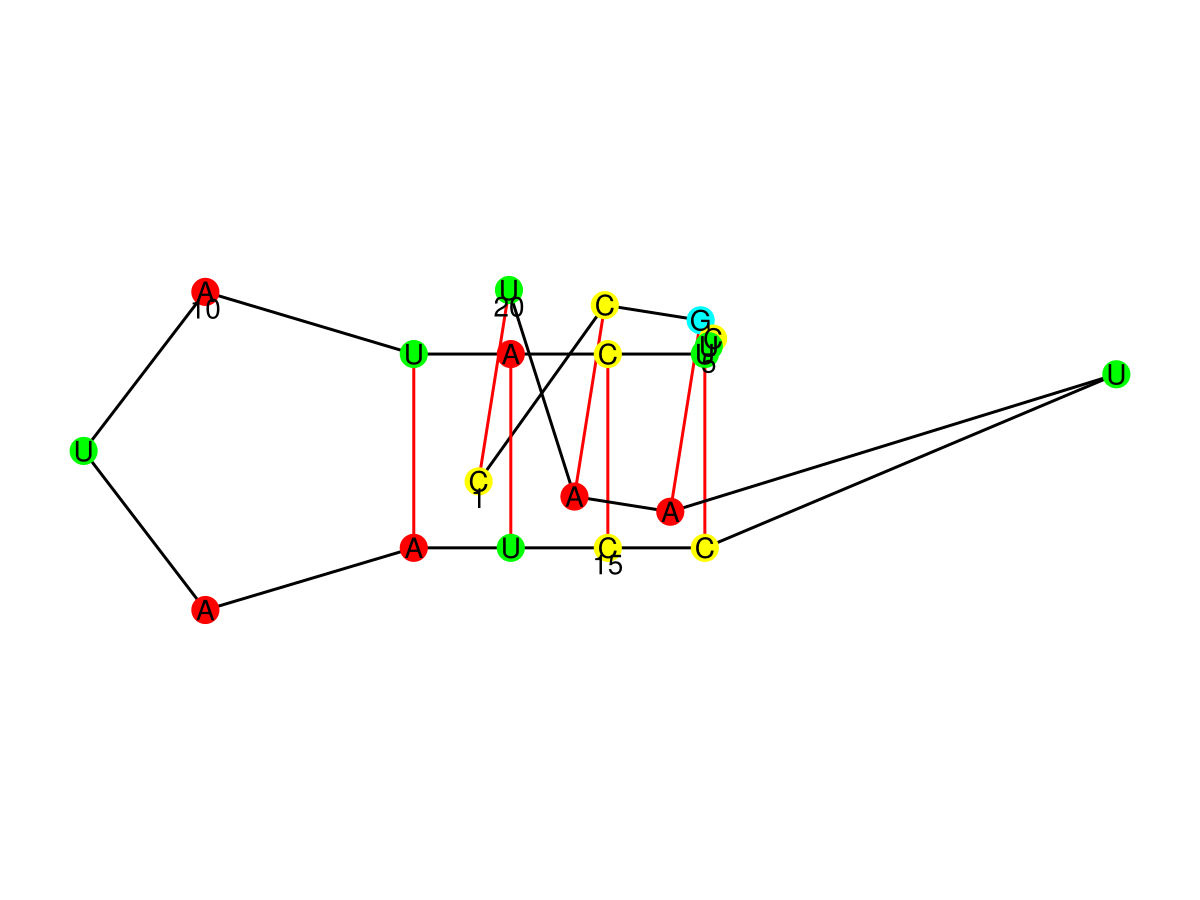

In [133]:
using CairoMakie

# f = Figure()
# ax = Axis(f[1,1],aspect=DataAspect())

function genadvanced(rnatree::RNATreeGraph, rnabase::RNABaseGraph)
    circ = gencircular(rnabase.graph)
    coords = Dict(v => [0.0, 0.0] for v in vertices(rnabase.graph))
    z = sort(collect(keys(rnatree.loopbases)))
    pairing = [(k, v) for (k, v) in rnatree.pairings]

    bigsize, bigvertex = findmax(v -> length(rnatree.loopbases[v]) , z)
    function genadvancedpart(treevertex, circlecenter, last=nothing, lastpair=nothing)
        loop = sort(rnatree.loopbases[treevertex])
        loopsize = length(loop)

        circleradius = 1/(2*sin(pi/loopsize))

        # determine region data
        regions = findregionstarts(rnatree, treevertex)
        n = length(loop)

        discovered = []
        # place region pairs
        for i in range(0, n-1)
            curr = loop[i%n+1]
            next = loop[(i+1)%n+1]
            small, big = sort([curr, next])

            # calculate angles from normal chords of adjacent region pairs 
            if (small, big) in pairing
                push!(discovered, (i%n+1, (i+1)%n+1))
                if (small, big) != lastpair
                    walkx, walky = (circ[next] - circ[curr]) #direction from region pair 1 to 2
                    perp = perpx, perpy = -walky, walkx # normal pointing outwards of the loop

                    # lin. equation of line between region pairs 
                    # and perpendicular intersection with (0,0)
                    slope, offset = paramline(circ[curr][1], circ[curr][2], circ[next][1], circ[next][2])
                    cut = cutx, cuty = intersection(slope, offset, 0, 0)

                    # calculate angle between outwards pointing normal and normalchord
                    angle = acos(clamp(dot(perp, (-1).*cut)/(norm(perp)*norm((-1).*cut)), -1, 1))
                    chordnormal = normalize([cutx, cuty])

                    # orient chordnormal to point outwards the loop
                    if abs(angle) > pi/2 
                        chordnormal *= -1
                    end
                    
                    cx, cy = chordnormal
                    #scatter!([cx], [cy], color=:red)
                    #arc!([0, 0], circleradius, pi, -pi)

                    chordangle = atan(cy, cx)
                    currangle = chordangle - pi/loopsize
                    nextangle = chordangle + pi/loopsize

                    currx, curry = circlecenter + circleradius .* [cos(currangle), sin(currangle)]
                    nextx, nexty = circlecenter + circleradius .* [cos(nextangle), sin(nextangle)]
                    coords[curr] = [currx, curry]
                    coords[next] = [nextx, nexty]

                    #lines!([currx, nextx], [curry, nexty])
                    #draw all pairs in region
                    edge, found = find_pairing((small, big), rnatree.regionpairs)
                    dir = chordnormal/2

                    lastseen = (small, big)
                    for (i, v) in enumerate(found)
                        cx, cy = [coords[curr][1], coords[curr][2]] + dir*(i-1)
                        nx, ny = [coords[next][1], coords[next][2]] + dir*(i-1)
                        
                        coords[v[1]] = [cx, cy]
                        coords[v[2]] = [nx, ny]

                        #lines!([cx, nx], [cy, ny])

                        lastseen = v
                    end

                    # set next vertex to neighbor
                    nextvertex = edge[1]==treevertex ? edge[2] : edge[1]
                    
                    nextloop = sort(rnatree.loopbases[nextvertex])
                    nextloopsize = length(nextloop)

                    nextcircleradius = 1/(2*sin(pi/nextloopsize))
                    
                    inp, outp = lastseen
                    mid = coords[inp] + (coords[outp]-coords[inp])/2
                    #scatter!([mid[1]], [mid[2]], color=:lime)
                    nextcirclecenter = mid + normalize(dir)*nextcircleradius
                    #scatter!([nextcirclecenter[1]], [nextcirclecenter[2]], color=:purple)
                    genadvancedpart(nextvertex, nextcirclecenter, treevertex, lastseen)
                end
            end
        end

        for i in range(0, length(discovered)-1)
            now = discovered[i%length(discovered)+1]
            advance = discovered[(i+1)%length(discovered)+1]

            startidx = now[2]
            stopidx = advance[1]
            start = normalize(coords[loop[startidx]]- circlecenter) 
            stop = normalize(coords[loop[stopidx]]- circlecenter) 

            startangle = atan(start[2], start[1])
            stopangle = atan(stop[2], stop[1])

            normalizeangle(θ) = θ < 0 ? θ + 2*pi : θ
            
            startangle = normalizeangle(startangle)
            stopangle = normalizeangle(stopangle)

            total = normalizeangle(stopangle-startangle)
            intervallength = intervalsize(startidx, stopidx, length(loop))
            segment = total/intervallength
            neededbases = intervallength-1
            
            println("-> Vertex: $(treevertex) Start: $(loop[startidx]) Stop: $(loop[stopidx]) Bases: $(neededbases)")
            println("startangle: $(round(rad2deg(startangle))) stopangle: $(round(rad2deg(stopangle)))")

            progress = 1
            for i in range(1, neededbases)
                baseangle = startangle + segment*progress
                coords[loop[(startidx+i-1)%n+1]] = (circleradius .* [cos(baseangle), sin(baseangle)]) + circlecenter
                progress += 1
            end
        end
    end
    genadvancedpart(1, [0, 0])
    return coords

end
coords = genadvanced(rnatree, rnabase)

draw_final(rnabase.graph, coords, rnabase.nucleotides, rnabase.pairings)

In [134]:
intervalsize(5, 2, 8)

5

In [135]:
rad2deg(3.04)

174.17916971977027